# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [2]:
def most_appropriate_label(data):
    label_values = np.unique(data)
    label_app_perc = np.zeros(len(label_values))
    for label in data:
        pos_idx = np.where(label_values == label)[0][0]
        label_app_perc[pos_idx] += 1
    label_app_perc /= len(data)
    return int(label_values[np.argmax(label_app_perc)]), np.max(label_app_perc)

def check_if_homogeneous(data, threshold = 0.8):
    if most_appropriate_label(data)[1] >= threshold:
        return True
    return False

def best_feat_splitting_point(best_feat_idx, split_thr, feature_set):
    best_feat = np.sort(extract_feat(best_feat_idx, feature_set))
    return (best_feat[split_thr - 1] + best_feat[split_thr]) / 2

def grow_tree(data, feature_set, feature_names, target_name, gini_instead_of_entropy = False):

    # TODO: Implement the rest of this function.
    # NOTE: You will need to come back to this function to make use of later functions.

    if check_if_homogeneous(data):
        return {"type": "leaf", "label": most_appropriate_label(data)[0]}
    best_feat_idx, split_thr, subset_l_feats, subset_r_feats, subset_l_labels, subset_r_labels = split_data(data, feature_set, gini_instead_of_entropy)
    splitting_point = best_feat_splitting_point(best_feat_idx, split_thr, feature_set)
    node = {"type": "node", "feature": feature_names[best_feat_idx], "feature_index": best_feat_idx, "splitting_point": splitting_point}
    if subset_l_labels.shape[0] != 0:
        node["left"] = grow_tree(subset_l_labels, subset_l_feats, feature_names, target_name, gini_instead_of_entropy)
    else:
        node["left"] = {"type": "leaf", "label": most_appropriate_label(data)[0]}
    if subset_r_labels.shape[0] != 0:
        node["right"] = grow_tree(subset_r_labels, subset_r_feats, feature_names, target_name, gini_instead_of_entropy)
    else:
        node["right"] = {"type": "leaf", "label": most_appropriate_label(data)[0]}
    return node 

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [ ]:
# TODO: Change the name of the functions and implement them as you see fit.

def stop1(...):

    pass 

def stop2(...):

    pass 


... # Add more stopping criterias if needed. Don't forget to use them when growing the tree!

### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [37]:
def calculate_probability(value, data):
    pb_value = np.where(data == value)[0].shape[0] / data.shape[0]
    return pb_value

def entropy(data):
    ent = 0
    for value in np.unique(data):
        ent += calculate_probability(value, data) * np.log(calculate_probability(value, data))
    ent = -ent
    return ent

def gini_index(data):
    gini = 1
    for value in np.unique(data):
        gini -= calculate_probability(value, data)**2
    return gini

# TODO: Change the name to which ever you chose.
def best_split_feature(data, feature_set, gini): 

    # TODO: Implement the rest of this function.
    # NOTE: Do not forget to have support for real and categorical features.
    split_thr = 1
    min_imp = 1
    for i in range(feature_set.shape[1]):
        feature = extract_feat(i, feature_set)
        for threshold in range(1, len(feature)):
            _, _, subset_l_labels, subset_r_labels = extract_subsets(data, feature_set, feature, threshold)
            if gini == False:
                imp = (subset_l_labels.shape[0] * entropy(subset_l_labels) + subset_r_labels.shape[0] * entropy(subset_r_labels)) / data.shape[0]
            else:
                imp = (subset_l_labels.shape[0] * gini_index(subset_l_labels) + subset_r_labels.shape[0] * gini_index(subset_r_labels)) / data.shape[0]
            if imp < min_imp:
                min_imp = imp
                best_feat_idx = i
                split_thr = threshold
    return best_feat_idx, split_thr


### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [38]:
def extract_feat(feat_idx, feature_set):
    feature = np.array([])
    for features in feature_set:
        feature = np.append(feature, float(features[feat_idx]))
    return feature

def extract_subsets(data, feature_set, feature, threshold):
    index_order = np.argsort(feature)
    subset_l_pos, subset_r_pos = index_order[:threshold], index_order[threshold:]
    subset_l_feats, subset_r_feats, subset_l_labels, subset_r_labels = np.asarray([]), np.asarray([]), np.asarray([]), np.asarray([])
    for pos in subset_l_pos:
        subset_l_feats = np.append(subset_l_feats, feature_set[pos], axis=0)
        subset_l_labels = np.append(subset_l_labels, int(data[pos]))
    for pos in subset_r_pos:
        subset_r_feats = np.append(subset_r_feats, feature_set[pos], axis=0)
        subset_r_labels = np.append(subset_r_labels, int(data[pos]))
    return subset_l_feats.reshape(len(subset_l_pos), feature_set.shape[1]).astype(float), subset_r_feats.reshape(len(subset_r_pos), feature_set.shape[1]).astype(float), subset_l_labels, subset_r_labels

def split_data(data, feature_set, gini_instead_of_entropy):

    # TODO: Implement the rest of this function.
    
    best_feat_idx, split_thr = best_split_feature(data, feature_set, gini_instead_of_entropy)
    best_feat = extract_feat(best_feat_idx, feature_set)
    subset_l_feats, subset_r_feats, subset_l_labels, subset_r_labels = extract_subsets(data, feature_set, best_feat, split_thr)
    return best_feat_idx, split_thr, subset_l_feats, subset_r_feats, subset_l_labels, subset_r_labels

### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [39]:
def predict_element(tree, test_element):
    if tree["type"] == "leaf":
        return tree["label"]
    elif tree["type"] == "node":
        if float(test_element[tree["feature_index"]]) <= float(tree["splitting_point"]):
            return predict_element(tree["left"], test_element)
        else:
            return predict_element(tree["right"], test_element)

def predict_with_tree(tree, test_set):

    # TODO: Implement the rest of this function.
    # NOTE: This function should also be recursive.

    predicted_result = np.zeros(test_set.shape[0]).astype("str")
    for i in range(test_set.shape[0]):
        predicted_result[i] = predict_element(tree, test_set[i])
    return predicted_result

## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [6]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [7]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred)

0.6

### 6) Dataset 1: Wine

ITERATION 0
implemented tree model accuracy: 0.8666666666666667
scikit tree model accuracy: 0.8444444444444444
ITERATION 1
implemented tree model accuracy: 0.8888888888888888
scikit tree model accuracy: 0.9777777777777777
ITERATION 2
implemented tree model accuracy: 0.8
scikit tree model accuracy: 0.9111111111111111
ITERATION 3
implemented tree model accuracy: 0.7555555555555555
scikit tree model accuracy: 0.8444444444444444
ITERATION 4
implemented tree model accuracy: 0.8222222222222222
scikit tree model accuracy: 0.8666666666666667
ITERATION 5
implemented tree model accuracy: 0.8888888888888888
scikit tree model accuracy: 1.0


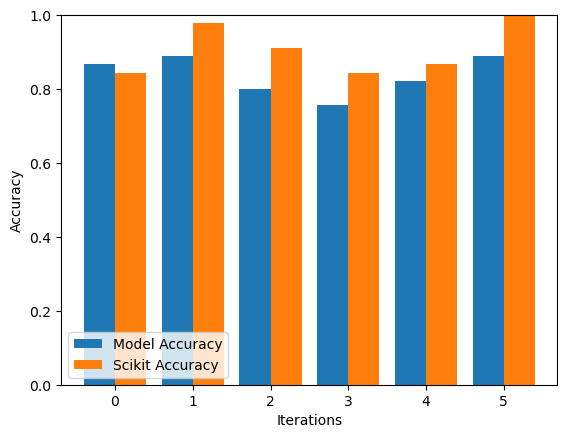

In [40]:
data_wine = pd.read_csv("wine.csv").to_numpy()

# TODO: Set up the data and split it into train and test-sets.
data_wine_feats_train, data_wine_feats_test, data_wine_labels_train, data_wine_labels_test = train_test_split(data_wine[1:, 0:-1], data_wine[1:, -1], random_state=0)
data_wine_feature_names, data_wine_target_name = pd.read_csv("wine.csv", nrows=0).columns.to_numpy()[0:-1], pd.read_csv("wine.csv", nrows=0).columns.to_numpy()[-1]

model_accuracies = np.array([])
scikit_accuracies = np.array([])

# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
def calculate_accuracy_model(train_feats, test_feats, train_labels, test_labels, feature_names, target_name):
    tree = grow_tree(train_labels, train_feats, feature_names, target_name)
    predicted_test_set_labels = predict_with_tree(tree, test_feats)
    actual_test_set_labels = test_labels
    data_wine_accuracy_model = accuracy_score(actual_test_set_labels, predicted_test_set_labels)
    return data_wine_accuracy_model

# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
def calculate_accuracy_scikit(train_feats, test_feats, train_labels, test_labels):
    dtc = DecisionTreeClassifier()
    dtc.fit(train_feats, train_labels)
    data_wine_labels_pred = dtc.predict(test_feats)
    data_wine_accuracy_sk = accuracy_score(test_labels, data_wine_labels_pred)
    return data_wine_accuracy_sk

def print_accuracy_both_models(train_feats, test_feats, train_labels, test_labels, feature_names, target_names, model_accuracies, scikit_accuracies):
    model_accuracy = calculate_accuracy_model(train_feats, test_feats, train_labels, test_labels, feature_names, target_names)
    model_accuracies = np.append(model_accuracies, model_accuracy)
    scikit_accuracy = calculate_accuracy_scikit(train_feats, test_feats, train_labels, test_labels)
    scikit_accuracies = np.append(scikit_accuracies, scikit_accuracy)
    print(f"ITERATION {len(model_accuracies) - 1}")
    print(f'implemented tree model accuracy: {model_accuracy}')
    print(f'scikit tree model accuracy: {scikit_accuracy}')
    return model_accuracies, scikit_accuracies

model_accuracies, scikit_accuracies = print_accuracy_both_models(data_wine_feats_train, data_wine_feats_test, data_wine_labels_train, data_wine_labels_test, data_wine_feature_names, data_wine_target_name, model_accuracies, scikit_accuracies)

# TODO: Do the above at least 5 times
# NOTE: Use loops here!
for i in range(5):
    data_wine_feats_train, data_wine_feats_test, data_wine_labels_train, data_wine_labels_test = train_test_split(data_wine[1:, 0:-1], data_wine[1:, -1])
    model_accuracies, scikit_accuracies = print_accuracy_both_models(data_wine_feats_train, data_wine_feats_test, data_wine_labels_train, data_wine_labels_test, data_wine_feature_names, data_wine_target_name, model_accuracies, scikit_accuracies)

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
fig, ax = plt.subplots()

x = np.arange(len(model_accuracies))
w = 0.4

ax.bar(x - w/2, model_accuracies, width=w, label="Model Accuracy")
ax.bar(x + w/2, scikit_accuracies, width=w, label="Scikit Accuracy")

ax.set_ylim(0, 1)
ax.set_xlabel("Iterations")
ax.set_ylabel("Accuracy")
ax.legend(loc="lower left")

plt.show()


### 7) Dataset 2: Heart Disease

In [ ]:
data_heart = pd.read_csv("heart.csv").to_numpy()

# TODO: Set up the data and split it into train and test-sets.

# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model

# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model

# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough

### 8) Dataset 3: Car

In [ ]:
data_car = pd.read_csv("car.csv").to_numpy()

# TODO: Set up the data and split it into train and test-sets.

# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model

# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model

# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough

### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

In [ ]:
from sklearn import preprocessing

# TODO: Use the wine dataset from above and scale its features (Not the labels!) between 0 and 1

# TODO: Run the code from the dataset and compare the preprocessed vs non-preprocessed data.
# NOTE: You can copy most of the workflow from the dataset code above to save you some time.
# NOTE: Use the same train/test split for your tree model for both the preprocessed vs non-preprocessed data.

# TODO: Do the above at least 5 times
# NOTE: Use loops here!

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?

4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!